1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```



32.97989825386221


/home/federico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.


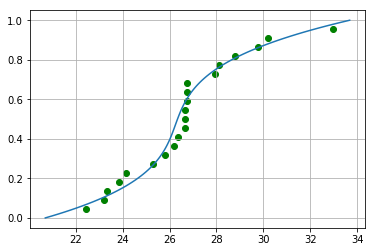

In [49]:
import numpy as np
from scipy.interpolate import UnivariateSpline

max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
cprob = (np.arange(years_nb, dtype=np.float32) + 1)/(years_nb + 1)
sorted_max_speeds = np.sort(max_speeds)

quantile_func = UnivariateSpline(cprob, sorted_max_speeds)
nprob = np.linspace(0, 1, 1e2)
fitted_max_speeds = quantile_func(nprob)

fifty_prob = 1. - 0.02
fifty_wind = quantile_func(fifty_prob)

print (fifty_wind)

plt.plot(quantile_func(nprob), nprob)
plt.scatter(sorted_max_speeds, cprob, color = 'g' )
plt.grid()
plt.show()

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.
* Define a function that can describe min and max temperatures. 
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

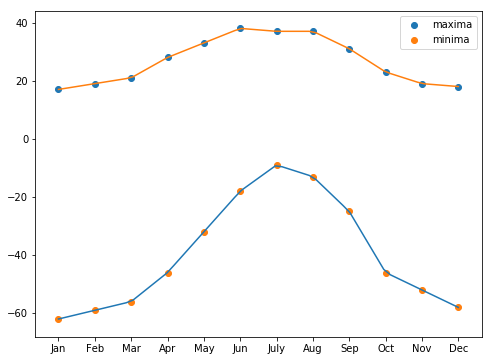

In [57]:
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d

maxima = [17,19,21,28,33,38,37,37,31,23,19,18]
minima = [-62,-59,-56,-46,-32,-18,-9,-13,-25,-46,-52,-58]
months = ['Jan','Feb','Mar','Apr','May','Jun','July','Aug','Sep','Oct','Nov','Dec']
interpolation_time = np.linspace(0,11,60)

cubic_interp1 = interp1d(np.linspace(0,11,12),minima)
cubic_interp2 = interp1d(np.linspace(0,11,12),maxima)
cubic_results1 = cubic_interp1(interpolation_time)
cubic_results2 = cubic_interp2(interpolation_time)

plt.figure(figsize=(8,6))
plt.plot(interpolation_time,cubic_results1)
plt.plot(interpolation_time,cubic_results2)
plt.scatter(months,maxima,label='maxima')
plt.scatter(months,minima,label='minima')
plt.legend(loc='best')

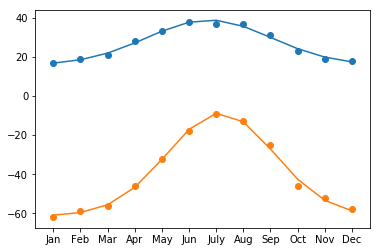

In [66]:
from scipy import optimize

def normal(x, mu, sig, offset, scale):
    return (np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))) + offset) * scale

params_M, params_covariance_M = optimize.curve_fit(normal, np.arange(12), maxima, p0=[7, 5, 0, 20])
params_m, params_covariance_m = optimize.curve_fit(normal, np.arange(12), minima, p0=[7, 5, -10, 30])

plt.scatter(months, maxima)
plt.plot(months,normal(np.arange(12), params_M[0], params_M[1], params_M[2], params_M[3]))
plt.scatter(months, minima)
plt.plot(months,normal(np.arange(12), params_m[0], params_m[1], params_m[2], params_m[3]))
plt.show()

3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


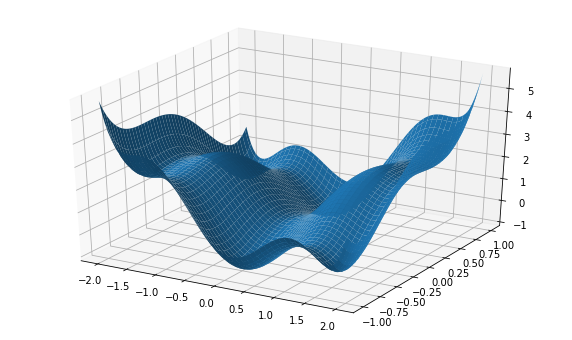

In [78]:
from mpl_toolkits.mplot3d import Axes3D

def f(x,y):
    return ((4-2.1*x**2+x**4/3)*x**2+x*y+(4*y**2-4)*y**2)

x1 = np.linspace(-2,2,100)
y1 = np.linspace(-1,1,100)

X,Y = np.meshgrid(x1, y1)
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, f(X, Y))
plt.show()

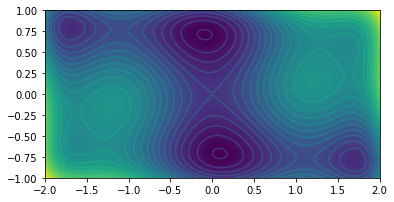

In [83]:
levels=np.arange(-2,6,0.25)

plt.imshow(f(X,Y),origin='lower', extent=[-2, 2, -1, 1]) # extent : (left, right, bottom, top)
plt.contour(X,Y,f(X,Y),levels=levels)
plt.show()

In [107]:
def f(coordinates):
    x,y=coordinates
    return ((4-2.1*x**2+x**4/3)*x**2+x*y+(4*y**2-4)*y**2)

x1 = np.linspace(-2,2,1000)
y1 = np.linspace(-1,1,1000)

solutions = [optimize.minimize(f,(x,y)) for x,y in zip(x1,y1)]
idx = np.argmin([solution.fun for solution in solutions])
solution = solutions[idx]
print("Min value: ",solution.fun)
print("Coordinates of the minimum: ",solution.x)

Min value:  -1.0316284534898774
Coordinates of the minimum:  [-0.08984201  0.71265641]


4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

[]

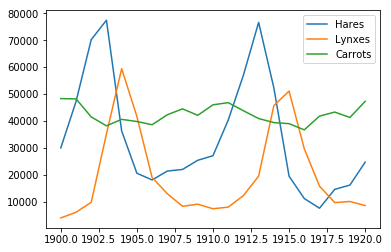

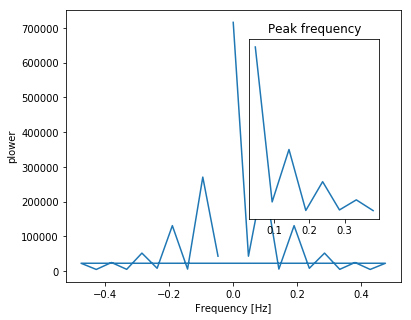

In [108]:
import numpy
from scipy import fftpack

data = numpy.genfromtxt('populations.txt',skip_header=0)

years = data[:,0]
hares = data[:,1]
lynxes = data[:,2]
carrots = data[:,3]

hares_period = 10
lynxes_period = 11

plt.plot(years,hares)
plt.plot(years,lynxes)
plt.plot(years,carrots)
plt.legend(['Hares','Lynxes','Carrots'])

hares_fft = fftpack.fft(hares)
power = np.abs(hares_fft)

# The corresponding frequencies
sample_freq = fftpack.fftfreq(hares.size, d=1)

# Plot the FFT power
plt.figure(figsize=(6, 5))
plt.plot(sample_freq, power)
plt.xlabel('Frequency [Hz]')
plt.ylabel('plower')

# Find the peak frequency: we can focus on only the positive frequencies
pos_mask = np.where(sample_freq > 0)
freqs = sample_freq[pos_mask]
peak_freq = freqs[power[pos_mask].argmax()]

# Check that it does indeed correspond to the frequency that we generate
# the signal with
np.allclose(peak_freq, 1./hares_period)

# An inner plot to show the peak frequency
axes = plt.axes([0.55, 0.3, 0.3, 0.5])
plt.title('Peak frequency')
plt.plot(freqs[:8], power[:8])
plt.setp(axes, yticks=[])

5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.

In [28]:
print (lynxes)

[ 4000.  6100.  9800. 35200. 59400. 41700. 19000. 13000.  8300.  9100.
  7400.  8000. 12300. 19500. 45700. 51100. 29700. 15800.  9700. 10100.
  8600.]


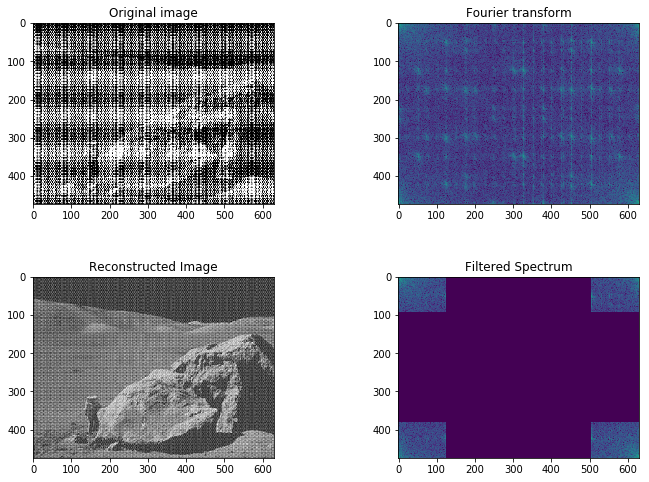

In [21]:
from scipy import fftpack

#the dynamic range of the Fourier coefficients (i.e. the intensity values in the Fourier image)
#is too large to be displayed on the screen, therefore all other values appear as black.
#If we apply a logarithmic transformation to the image
def spectrum(F):
    plt.imshow(np.log(5+np.abs(F)))

# read image
image = plt.imread('moonlanding.png').astype(float)

# Compute the 2d FFT of the input image
F = fftpack.fft2(im)

# Define the fraction of coefficients (in each direction) we keep
keep_fraction = 0.2

# Call ff a copy of the original transform. Numpy arrays have a copy
# method for this purpose.
ff = F.copy()

# Set r and c to be the number of rows and columns of the array.
r, c = ff.shape

# Set to zero all rows with indices between r*keep_fraction and # r*(1-keep_fraction):
ff[int(r*keep_fraction):int(r*(1-keep_fraction))] = 0

# Similarly with the columns:
ff[:, int(c*keep_fraction):int(c*(1-keep_fraction))] = 0

# Reconstruct the denoised image from the filtered spectrum, keep only the
# real part for display.
im_new = fftpack.ifft2(ff).real

# Show the results
plt.figure(figsize=(12,8))
plt.subplot(221)
plt.title('Original image')
plt.imshow(im,plt.cm.gray)
plt.subplot(222)
plt.title('Fourier transform')
spectrum(F)
plt.subplot(224)
plt.title('Filtered Spectrum')
spectrum(ff)
plt.subplot(223)
plt.title('Reconstructed Image')
plt.imshow(im_new, plt.cm.gray)

# Adjust the spacing between subplots for readability
plt.subplots_adjust(hspace=0.4)

plt.show()


